In [1]:
import zipfile

zip_path = "Resources.zip" 
extract_to = "Resources"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [3]:
import os
data_path = "../Resources/training"  # Adjust path to reflect the new location

In [4]:
!pip install nibabel
!pip install monai==1.0.0

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import glob
import nibabel as nib
import numpy as np
import monai

def get_ed_es_frames(config_path):
    """Extract ED and ES frame numbers from the info.cfg file."""

    ed_frame, es_frame = None, None
    with open(config_path, 'r') as f:
        for line in f:
            if line.startswith('ED:'):
                ed_frame = int(line.split(':')[1].strip())
            elif line.startswith('ES:'):
                es_frame = int(line.split(':')[1].strip())
    return ed_frame, es_frame


2025-03-07 15:35:11.130586: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 15:35:11.176624: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 15:35:11.176657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 15:35:11.176692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 15:35:11.188007: I tensorflow/core/platform/cpu_feature_g

In [6]:
def build_dict_acdc(data_path, mode='train', train_patients=None):
    """
    This function returns a list of dictionaries containing paths to the 2D slices of the 3D MRI images
    and their corresponding masks, filtered by the selected patients.
    """
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    dicts = []
    
    # Use either train or validation patients based on the mode
    if mode == 'train':
        selected_patients = train_patients
    elif mode == 'val':
        selected_patients = val_patients
    
    for patient_dir in selected_patients:
        patient_id = os.path.basename(patient_dir)
        config_path = os.path.join(patient_dir, "Info.cfg")
        
        if not os.path.exists(config_path):
            continue
        
        ed_frame, es_frame = get_ed_es_frames(config_path)
        
        # Identify the ED and ES image and mask paths
        ed_img_path = os.path.join(patient_dir, f"{patient_id}_frame{ed_frame:02d}.nii.gz")
        ed_mask_path = os.path.join(patient_dir, f"{patient_id}_frame{ed_frame:02d}_gt.nii.gz")
        es_img_path = os.path.join(patient_dir, f"{patient_id}_frame{es_frame:02d}.nii.gz")
        es_mask_path = os.path.join(patient_dir, f"{patient_id}_frame{es_frame:02d}_gt.nii.gz")
        
        for img_path, mask_path in [(ed_img_path, ed_mask_path), (es_img_path, es_mask_path)]:
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue
            
            # Load the 3D image and mask using nibabel
            img_volume = nib.load(img_path).get_fdata()
            mask_volume = nib.load(mask_path).get_fdata()
            
            # Ensure we have the same number of slices for image and mask
            num_slices = img_volume.shape[2]
            
            # Extract 2D slices
            for slice_idx in range(num_slices):
                img_slice = img_volume[:, :, slice_idx]
                mask_slice = mask_volume[:, :, slice_idx]
                
                dicts.append({'img': img_slice, 'mask': mask_slice})
    
    return dicts


In [7]:
class LoadHeartData(monai.transforms.Transform):
    """
    This custom Monai transform loads 2D slices of MRI data and their corresponding mask for heart segmentation.
    """
    def __init__(self, keys=None):
        pass
    
    def __call__(self, sample):
        img_slice = sample['img']
        mask_slice = sample['mask'] 
        
        # Ensure the image and mask are in compatible formats
        img_slice = np.array(img_slice, dtype=np.float32)
        mask_slice = np.array(mask_slice, dtype=np.uint8) 
        
        # Return the slice and mask with metadata. NOT SURE ABOUT THE METATDATA
        return {'img': img_slice, 'mask': mask_slice, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

In [8]:
from sklearn.model_selection import train_test_split

# Get patient directories
patient_dirs = [d for d in glob.glob(os.path.join(data_path, '*')) if os.path.isdir(d)]

# Split patients into train and validation sets
train_patients, val_patients = train_test_split(patient_dirs, test_size=0.2, random_state=42)

# Construct the list of dictionaries for the train and validation sets based on patient directories
train_dict = build_dict_acdc(data_path, mode='train', train_patients=train_patients)
val_dict = build_dict_acdc(data_path, mode='val', train_patients=val_patients)

# Construct CacheDataset from the list of dictionaries and apply the transform
train_dataset = monai.data.CacheDataset(data=train_dict, transform=LoadHeartData())
val_dataset = monai.data.CacheDataset(data=val_dict, transform=LoadHeartData())

Loading dataset: 100%|██████████| 390/390 [00:00<00:00, 2357.79it/s]


In [17]:
# Print the dimensions of some random images and masks
import random
random_indices_dimensions = random.sample(range(len(train_dataset)), 20)  # Get 10 random indices

for i in random_indices_dimensions:
    sample = train_dataset[i] 
    print("Image shape:", sample["img"].shape)
    print("Mask shape:", sample["mask"].shape)

# Dimensions vary!

Image shape: (224, 154)
Mask shape: (224, 154)
Image shape: (224, 154)
Mask shape: (224, 154)
Image shape: (208, 256)
Mask shape: (208, 256)
Image shape: (216, 256)
Mask shape: (216, 256)
Image shape: (216, 256)
Mask shape: (216, 256)
Image shape: (232, 256)
Mask shape: (232, 256)
Image shape: (216, 256)
Mask shape: (216, 256)
Image shape: (216, 256)
Mask shape: (216, 256)
Image shape: (208, 256)
Mask shape: (208, 256)
Image shape: (216, 256)
Mask shape: (216, 256)
Image shape: (216, 304)
Mask shape: (216, 304)
Image shape: (180, 224)
Mask shape: (180, 224)
Image shape: (256, 216)
Mask shape: (256, 216)
Image shape: (224, 154)
Mask shape: (224, 154)
Image shape: (240, 256)
Mask shape: (240, 256)
Image shape: (216, 256)
Mask shape: (216, 256)
Image shape: (184, 256)
Mask shape: (184, 256)
Image shape: (154, 224)
Mask shape: (154, 224)
Image shape: (216, 256)
Mask shape: (216, 256)
Image shape: (256, 208)
Mask shape: (256, 208)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_heart_sample(sample, title=None):
    """
    Visualize the MRI image of the heart and overlay the segmentation mask on top of it.
    """
    # Get the image and mask from the sample
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    
    # Create the plot
    plt.figure(figsize=[10,7])
    
    # Display the MRI image in grayscale
    plt.imshow(image, cmap='gray')
    
    # Overlay the mask 
    overlay_mask = np.ma.masked_where(mask == 0, mask)  # Mask out the background
    
    # Overlay the mask on top of the image
    plt.imshow(overlay_mask, alpha=0.7, interpolation='nearest') # Not needed to use clim[0,1] because the mask is not binary in this case
    
    # Optionally set a title
    if title is not None:
        plt.title(title)
    
    plt.axis('off')
    plt.show()


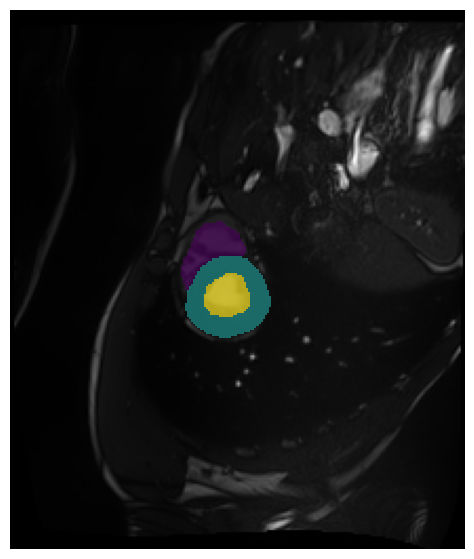

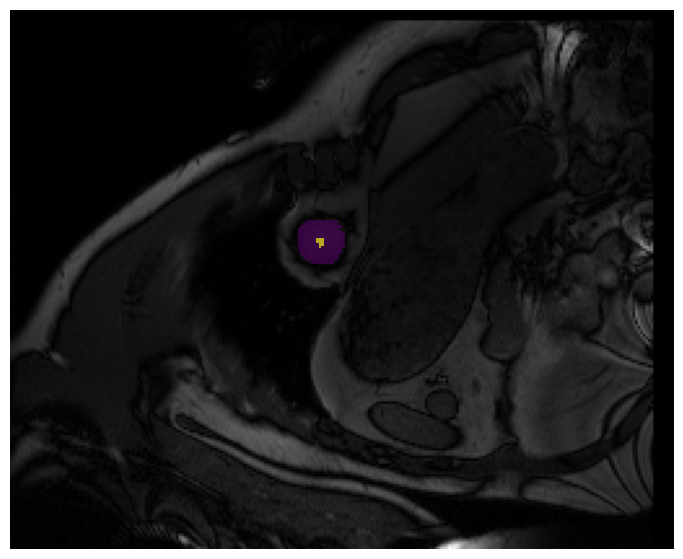

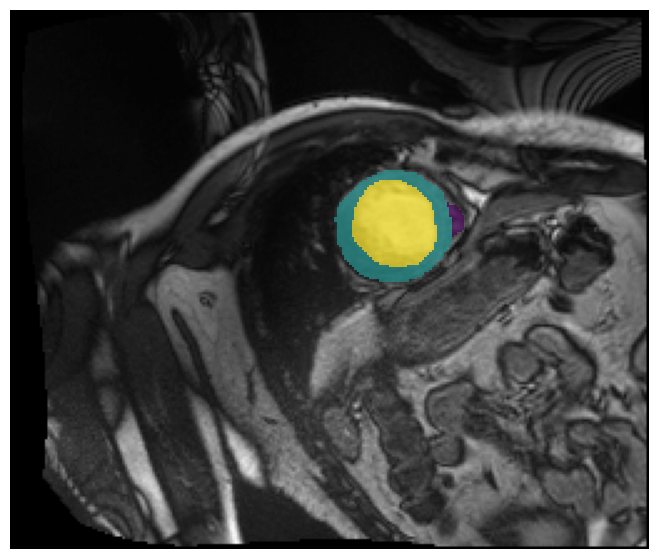

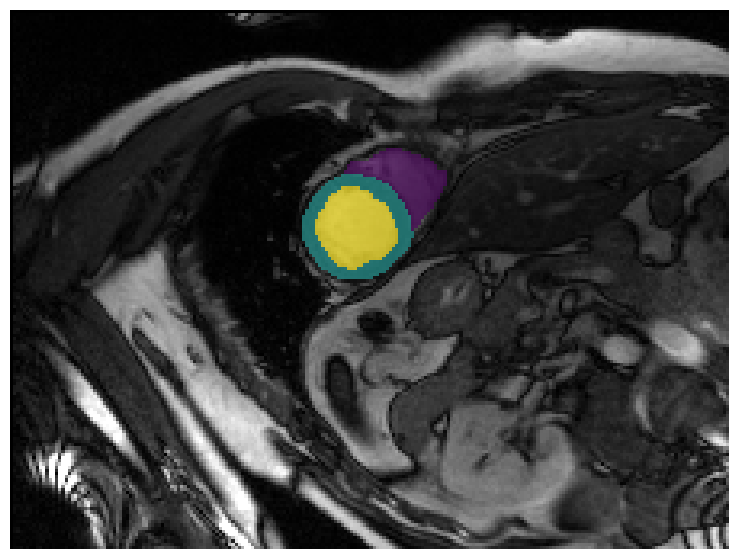

In [14]:
# Visualize random samples from the training set with the overlaying mask
random_indices_visualize = random.sample(range(len(train_dataset)), 4)  

for i in random_indices_visualize:
    sample = train_dataset[i]
    visualize_heart_sample(sample)

Loading dataset: 100%|██████████| 1512/1512 [00:15<00:00, 96.39it/s] 


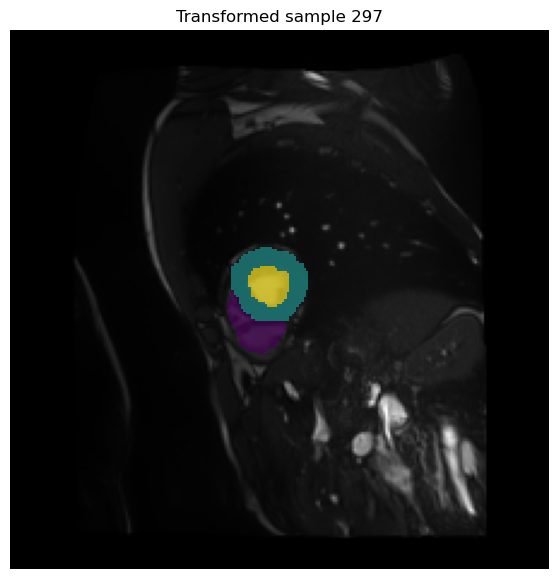

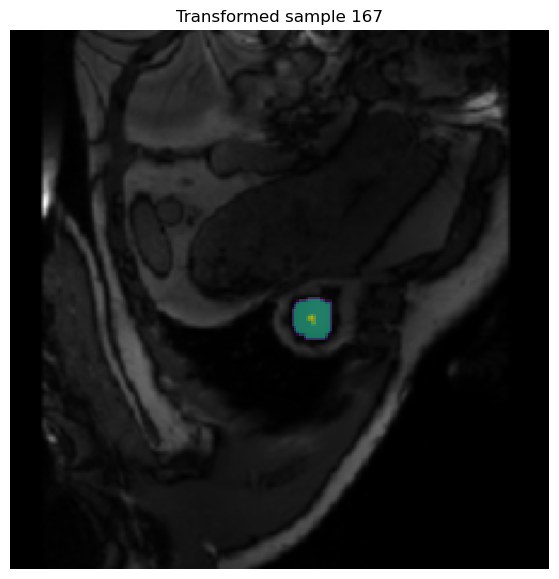

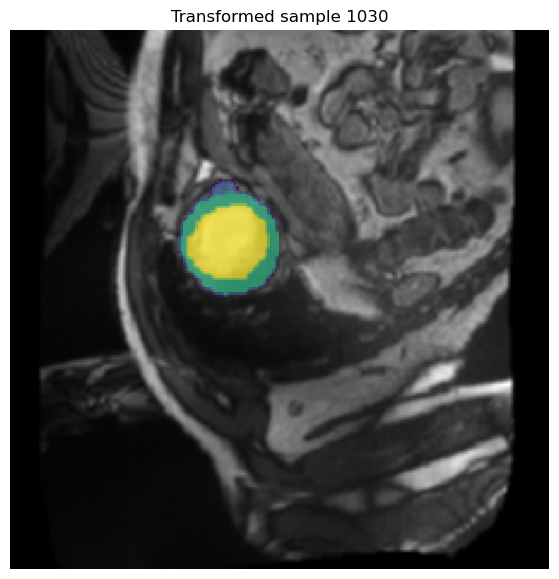

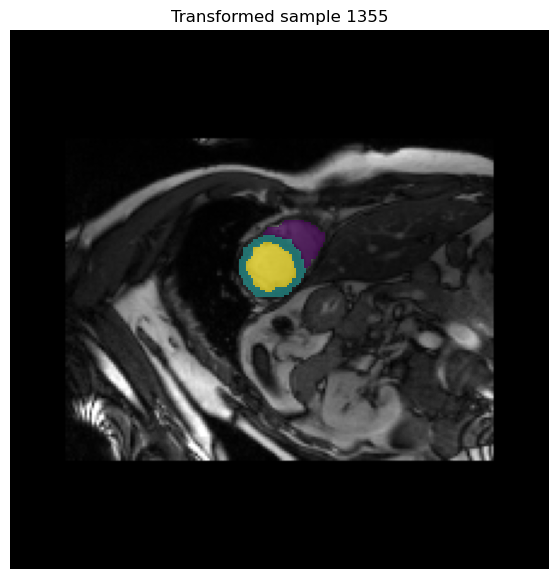

In [23]:
# Data augmentation for training data
transform_training = monai.transforms.Compose([
    LoadHeartData(),  # Load the rib data (must be first!)
    monai.transforms.AddChanneld(keys=['img', 'mask']),  # Add channel dimension for img and multilabel mask
    monai.transforms.ScaleIntensityd(keys=['img'], minv=0, maxv=1),  # Normalize intensity
    monai.transforms.Spacingd(keys=['img', 'mask'], pixdim=(1.25, 1.25), mode=("bilinear", "nearest")), # Resample voxel spacing in x and y
    monai.transforms.ResizeWithPadOrCropd(keys=['img', 'mask'], spatial_size=[224, 224]), # Ensures all images have the same dimensions (without getting stretched out). 
    monai.transforms.RandZoomd(keys=['img', 'mask'], prob=0.5, min_zoom=0.8, max_zoom=1.2, keep_size=True), # Random zoom, not too much so that you don't remove important parts 
    monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=0),  # Random flip. Spatial axis=0 for up-down flipping. Left-right flipping is not good because the model has to distinguish the left and right ventricle
    monai.transforms.RandRotate90d(keys=['img', 'mask'], prob=0.5, max_k=1), # 90-degree rotation (max 1, so that left-right orientation is not disrupted).
    monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=[256,256], random_size=False),  # Random crop
    monai.transforms.RandShiftIntensityd(keys=['img'], offsets=0.05, prob=0.5),  # Shift intensity for brightness variation
])

train_dataset = monai.data.CacheDataset(train_dict, transform=transform_training) # Like before

for i in random_indices_visualize:
    visualize_heart_sample(train_dataset[i], title=f"Transformed sample {i}")

Loading dataset: 100%|██████████| 390/390 [00:03<00:00, 102.62it/s]


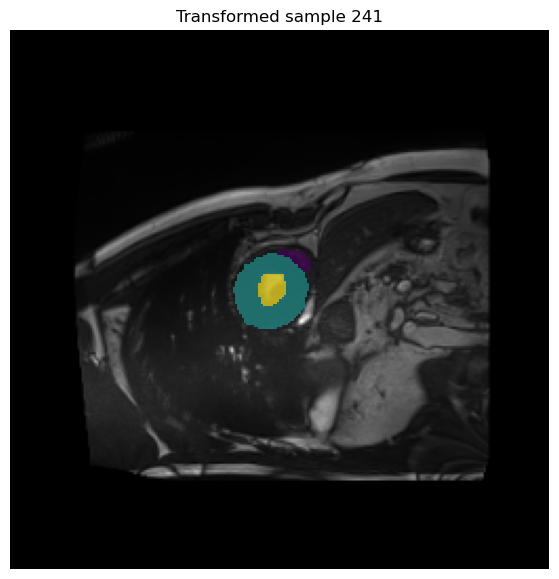

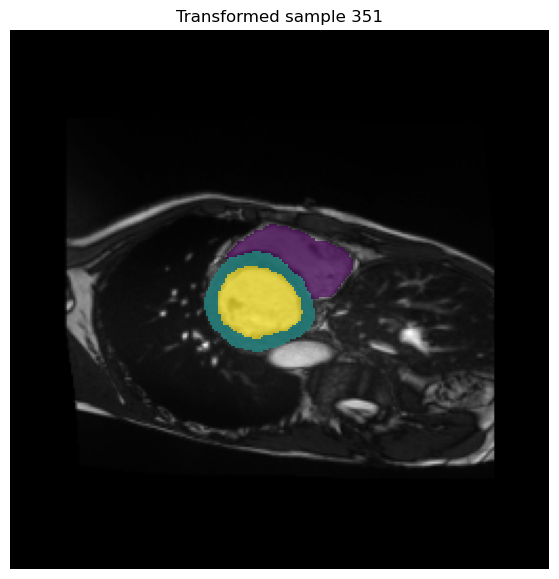

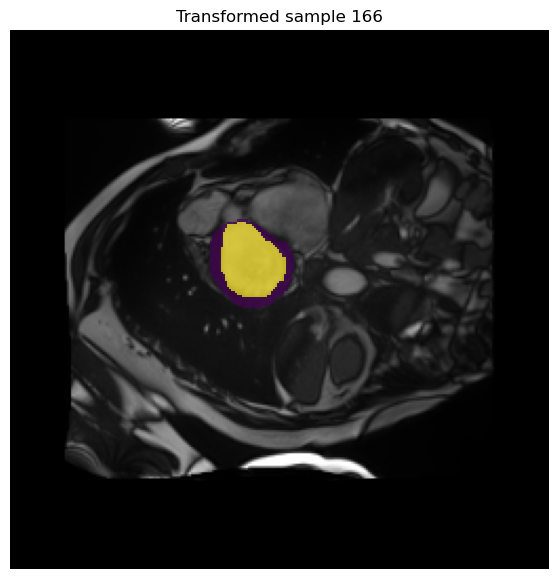

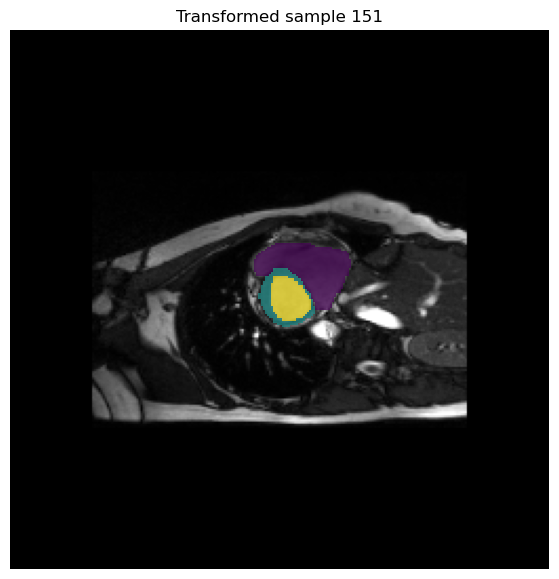

In [26]:
# No random transformations for validation.
transform_validation = monai.transforms.Compose([
    LoadHeartData(),  # Load the heart data (must be first!)
    monai.transforms.AddChanneld(keys=['img', 'mask']),  # Add channel dimension for img and multilabel mask
    monai.transforms.ScaleIntensityd(keys=['img'], minv=0, maxv=1),  # Normalize intensity to the range [0, 1]
    monai.transforms.Spacingd(keys=["img", "mask"], pixdim=(1.25, 1.25), mode=("bilinear", "nearest")),  # Resample voxel spacing in x and y
    monai.transforms.ResizeWithPadOrCropd(keys=['img', 'mask'], spatial_size=[256, 256]),  # Ensure consistent size [256, 256]
])

val_dataset = monai.data.CacheDataset(val_dict, transform=transform_validation) # Like before

random_indices_visualize_val = random.sample(range(len(val_dataset)), 4)  
for i in random_indices_visualize_val:
    visualize_heart_sample(val_dataset[i], title=f"Transformed sample {i}")

In [27]:
# Data loader
train_dataloader = monai.data.DataLoader(train_dataset, batch_size=16, shuffle=True)